In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import sympy
from scipy.linalg import expm
import scipy.constants as sc
from tqdm import tqdm_notebook
from scipy.fft import fft,ifft,fftfreq, dct, idct
from itertools import combinations
import pandas as pd
import seaborn as sns
from objsize import get_deep_size
from scipy import linalg
import datetime
import os

C:\Users\david\anaconda3\lib\site-packages\ipykernel_launcher.py:214: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Save Data?1


C:\Users\david\anaconda3\lib\site-packages\ipykernel_launcher.py:238: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


987.0


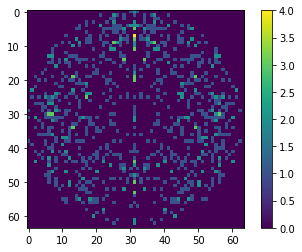

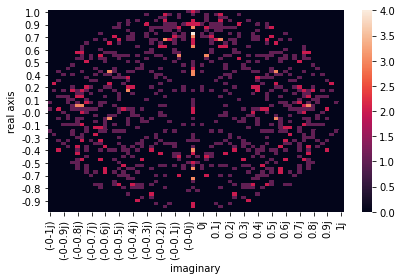

mean r value = 0.7068429975453505
mean cos(theta) = -0.06643352682131032
mean theta = 0.014851120715771823


In [17]:
class lindbladian_Louville_operator():
    def __init__(self,N,h,J,b,t,tau,nv,
                gamma0,gamma_L_plus,gamma_L_min,gamma_R_plus,gamma_R_min):
        
        for local in locals().copy(): 
            ## equivalent of writing self.gamma = gamma,self.b = b etc.
            ## without having to rewrite it.
            exec('self.' + local +  ' = locals()[local]')
        
        ###initialising variables so they don't have to called in 
        ###each function
        self.initialise_variables()
        
        self.L = self.L()
        
        self.P,self.evecs,self.evals = self.P()
        
        self.z_k = self.z_k(self.evals)
        
        self.save_boolean = bool(int(input('Save Data?')))
        self.path = 'C://Users/david/OneDrive/Documents/UNI/UCL project/data/Single number signatures/'  
        self.heatmap(self.z_k)
        
        self.mean_r, self.mean_cos, self.mean_theta = self.single_number_signatures(self.z_k)
        print('mean r value = '+ str(self.mean_r))
        print('mean cos(theta) = '+str(self.mean_cos))
        print('mean theta = '+str(self.mean_theta))
        data_list = ['mean_r='+str(self.mean_r),
                     'mean_cos='+str(self.mean_cos),
                     'mean_theta='+str(self.mean_theta),
                     'N='+str(self.N),'h='+str(self.h),
                     'J='+str(self.J),'b='+str(self.b),
                     't='+str(self.t),'tau='+str(self.tau),
                     'nv='+str(self.nv),'gamma0='+str(self.gamma0),
                     'gamma_L_plus='+str(self.gamma_L_plus),
                     'gamma_L_min='+str(self.gamma_L_min),
                     'gamma_R_plus='+str(self.gamma_R_plus),
                     'gamma_R_min='+str(self.gamma_R_min)]
        
        data_array = np.asarray((self.mean_r,self.mean_cos,
                     self.mean_theta,self.N,self.h,
                     self.J,self.b,self.t,self.tau,
                     self.nv,self.gamma0,self.gamma_L_plus,
                     self.gamma_L_min,self.gamma_R_plus,
                     self.gamma_R_min))
        
        
        
            
        if self.save_boolean:
            list_name = 'list, N = '+str(self.N) + ', h = '+str(self.h) +', ' +str(datetime.datetime.today().date())
            array_name = 'array, N = '+str(self.N) + ', h = '+str(self.h) +', ' +str(datetime.datetime.today().date())
            heatmap_data_name = 'heatmap matrix, N = '+str(self.N) + ', h = '+str(self.h) +', ' +str(datetime.datetime.today().date())
            self.path = 'C://Users/david/OneDrive/Documents/UNI/UCL project/data/Single number signatures/'  
            self.list_path = self.path+list_name
            self.array_path = self.path+array_name
            self.heatmap_data_path = self.path+heatmap_data_name
            
            
            np.save(self.list_path+'.npy',data_list)
            np.save(self.array_path+'.npy',data_array)
            
            
        



    def initialise_variables(self,):

        ####gamma is an array of 5 constants that control the dissipation 

        si = qeye(2) #identity for a spin-1/2 particle
        sz = sigmaz() ## z pauli matrix
        sx = sigmax() ## x pauli matrix
        sigp = sigmap() ##plus ladder operator for spin 1/2
        sigm = sigmam() ##minus ladder operator for spin 1/2
        sz_list = []
        sx_list = []
        sigp_list = []
        sigm_list = []
        h_arr = np.random.uniform(-self.h,self.h,self.N) ##random uniform distribution from -h to h

        for n in range(self.N):
            op_list = []
            for m in range(self.N):
                op_list.append(si) ##creates a list of identity operators for each particle
            self.identity = tensor(op_list) ##creates an identity over the 4^N x 4^N space
            op_list[n] = sz
            sz_list.append(tensor(op_list))

            op_list[n] = sx
            sx_list.append(tensor(op_list))
            ###could get greater efficiency by just calculating the plus/minus 
            ### at the boundaries where they're needed
            if n==0:
                op_list[n] = sigp
                sigp_list.append(tensor(op_list))

                op_list[n] = sigm
                sigm_list.append(tensor(op_list))
            if n==self.N-1:
                op_list[n] = sigp
                sigp_list.append(tensor(op_list))

                op_list[n] = sigm
                sigm_list.append(tensor(op_list))

        # construct the hamiltonian 
        H_S = 0
         ##bulk dephasing
        W_list = [] ##list of jump operators

        # energy splitting terms
        for n in range(self.N):
            H_S += h_arr[n] * sz_list[n] ##random field term

            ##bulk dephasing
            W_list.append(np.sqrt(self.gamma0) * sz_list[n])
        
        ##amplitude damping
        W_list.append(np.sqrt(self.gamma_L_plus)*sigp_list[0]) ##W_{N+1}
        W_list.append(np.sqrt(self.gamma_L_min)*sigp_list[1]) ##W_{N+2}
        W_list.append(np.sqrt(self.gamma_R_plus)*sigm_list[0]) ##W_{N+3}
        W_list.append(np.sqrt(self.gamma_R_min)*sigm_list[1]) ##W_{N+4}
                
        
        self.W_list = W_list
        self.sigp_list = sigp_list
        self.sigm_list = sigm_list

        # interaction terms
        for n in range(self.N-1): 
            H_S += self.J * sz_list[n] * sz_list[n+1]

        self.H1 =H_S
        ##kicking term
        self.Hk = 0
        for n in range(self.N):
                self.Hk += self.b * sx_list[n]

    def L(self,):
        ###creates L from the definition of its matrix representation, 
        ###equation 4.1 of the notes currently
        
        W_term = 0 
        ###calculates sum_{\mu}(W_{\mu}^{\dag}*W_{\mu})
        for i in range(len(self.W_list)):
            W_term += self.W_list[i]*(self.W_list[i].dag())
               
        H_left = self.H1 - (1j/2)*W_term
        H_right = self.H1 + (1j/2)*W_term

        H_cross_term = 0
        ##calculates  sum_{\mu}(W_{\mu}\otimes W_{\mu}^{\dag})
        for i in range(len(self.W_list)):
            H_cross_term += tensor(self.W_list[i],self.W_list[i].dag())

        L = -1j*tensor(H_left,self.identity)
        L += 1j*tensor(self.identity,H_right.trans())
        L += H_cross_term
        return L
    
    def P(self,):
        
        ##reducing the precision of Qobjs to reduce data size
        #self.L[:] = self.L[:].astype(np.csingle)
        #self.Hk[:] = self.Hk[:].astype(np.csingle)
        #self.identity[:] = self.identity[:].astype(np.csingle)
        
        ##using tidyup doesnt do much
        #self.L.tidyup()
        #self.Hk.tidyup()
        #self.identity.tidyup()
        
        
        ##defining the commutator kicking superoperator
        HK_commute_SO = -1j*tensor(self.Hk,self.identity)
        HK_commute_SO += 1j*tensor(self.identity,self.Hk.trans())
        
        ###exponentiates the matrices and calculates P
        expH = HK_commute_SO.expm()
        exp1 = (self.L*self.tau/2).expm()
        exp2 = (self.L*(self.t-self.tau/2)).expm()
        P = exp2*(expH*exp1)
        evals = P.eigenstates()[0]
        evecs = P.eigenstates()[1]
        

#         """array method to try and reduce data"""
#         L_arr = np.asarray(self.L,dtype=np.complex64)
#         Hk_arr = np.asarray(HK_commute_SO,dtype=np.complex64)
#         identity_arr = np.asarray(self.identity,dtype=np.complex64)
        
#         expH_arr = linalg.expm(Hk_arr)
#         exp1_arr = linalg.expm(L_arr*self.tau/2)
#         exp2_arr = linalg.expm(L_arr*(self.t - self.tau/2))
        
#         P_arr = exp2_arr*(expH_arr*exp1_arr)
#         P = Qobj(P_arr)
        
        return P,evecs,evals
    







    #'''''''''''''''''Level Statistics functions''''''''''''''''''''''
    def z_k(self,E_array):
        z_k = [] ##setting up ratio array

        for i in tqdm_notebook(range(np.size(E_array)),leave=False):
            ###creating an array of the indices of the ratios ascending in magnitude from 
            ##the ith ratio
            E_idx_sorted = np.argsort(np.abs(E_array-E_array[i]))
            NN = E_array[E_idx_sorted[1]] ##takes the first one
            NNN = E_array[E_idx_sorted[2]] ##takes the second one
            
            ##definition of z_k
            z_k.append((NN-E_array[i])/(NNN-E_array[i]))
        z_k = np.asarray(z_k) 
        return z_k

    def heatmap(self,z_k):
       
        ##creating grid in complex space
        real_vals = np.linspace(-1,1,self.nv)
        imag_vals = 1j*np.linspace(-1,1,self.nv)
        
        ##creating empty 2D array for heatmap values
        heatmap_vals = np.zeros((self.nv,self.nv)) 
        
        ##resolution of grid
        delta = (np.max(real_vals)-np.min(real_vals))/np.size(real_vals)
        
        for i in tqdm_notebook(range(self.nv),leave=False):
            for j in range(self.nv):
                ##recentres z_k so origin is at (real_vals[i],imag_vals[j])
                recentred_z_k = z_k - real_vals[i] - imag_vals[j]
        
                    
                ##creates booleans in order to get rid of any values
                ##that don't lie in the ith,jth square of the grid
                real_bool =(recentred_z_k.real>=0)*(recentred_z_k.real<=delta) 
                imag_bool =(recentred_z_k.imag>=0)*(recentred_z_k.imag<=delta)
    
    
                
                ##summing up how many non-zero values there are
                rho = np.sum(real_bool*imag_bool)
                heatmap_vals[i,j] = rho
        print(np.sum(heatmap_vals))
        
            
        
        plt.imshow(heatmap_vals)
        plt.colorbar()
        plt.show()
        
       
        ##plotting a seaborn heatnap
        df = pd.DataFrame(data=heatmap_vals,index = np.round(-real_vals,1), columns=np.round(imag_vals,1))
        sns.heatmap(df)
        plt.xlabel('imaginary')
        plt.ylabel('real axis')
        if self.save_boolean:
            plt.gcf().tight_layout()
            self.graph_path = 'heatmap , N = '+str(self.N) + ', h = '+str(self.h) +', ' +str(datetime.datetime.today().date())
            plt.savefig(self.path+'/'+self.graph_path+'.png',dpi=250)
            
        plt.show()

    
    def single_number_signatures(self,z_k):
        theta = np.angle(z_k)
        cos_theta = np.cos(theta)
        mean_cos = np.mean(cos_theta)
        mean_theta = np.mean(theta)
        r = np.abs(z_k)
        mean_r = np.mean(r)
        return mean_r, mean_cos, mean_theta
    

method = lindbladian_Louville_operator(N=5,h=3,J=1,b=1,
                                       t=0.7,tau=1,nv=64,
                                       gamma0=1,gamma_L_plus=1,gamma_L_min=1,gamma_R_plus=1,gamma_R_min=1)





In [112]:
method.L

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], shape = (1048576, 1048576), type = oper, isherm = False
Qobj data =
  (0, 0)	(-1.5+0j)
  (1, 1)	(-1.5-2j)
  (1, 1024)	(0.5000000000000001+0j)
  (2, 2)	(-1.5-4j)
  (3, 3)	(-1.5-2j)
  (3, 1026)	(0.5000000000000001+0j)
  (4, 4)	(-1.5-4j)
  (5, 5)	(-1.5-6j)
  (5, 1028)	(0.5000000000000001+0j)
  (6, 6)	(-1.5-4j)
  (7, 7)	(-1.5-2j)
  (7, 1030)	(0.5000000000000001+0j)
  (8, 8)	(-1.5-4j)
  (9, 9)	(-1.5-6j)
  (9, 1032)	(0.5000000000000001+0j)
  (10, 10)	(-1.5-8j)
  (11, 11)	(-1.5-6j)
  (11, 1034)	(0.5000000000000001+0j)
  (12, 12)	(-1.5-4j)
  (13, 13)	(-1.5-6j)
  (13, 1036)	(0.5000000000000001+0j)
  (14, 14)	(-1.5-4j)
  (15, 15)	(-1.5-2j)
  (15, 1038)	(0.5000000000000001+0j)
  (16, 16)	(-1.5-4j)
  :	:
  (1048559, 1048559)	(-1.0000000000000002-4j)
  (1048560, 1047537)	(0.5000000000000001+0j)
  (1048560, 1048560)	(-1.0000000000000002-2j)
  (1048561, 

In [95]:


###works up up to the limit**2 (limit of the while loop)
def my_expm(A):
    ####reduces precision
    A = np.asarray(A)
    
    m,n = np.shape(A)
    k = 0
    fact = 1
    matpow = np.eye(n)
    expmat = np.matrix(np.zeros([n,n]))
    lastnorm = 1
    while lastnorm > 1e-4:
        expmat = expmat + matpow/fact
        lastnorm = np.max(abs(matpow/fact))
        k += 1
        if k ==170: ##computer can't handle factors when they're this large
            break
        fact *= k
        matpow = A@matpow
        if k%10 ==0:
            print(k)
    return expmat


#do diagonalisation method for expA
def my_expm2(A):
    m,n = np.shape(A)
    evecs = A.eigenstates()[1]
    evals = A.eigenstates()[0]
    diag_A = np.diag(evals)
    D = np.zeros(np.shape(A),dtype=np.csingle)
    for i in range(n):
        D[:,i] = np.asarray(evecs[i]).reshape(n)
    D = Qobj(D)
    D_inv = D.inv()
    k = 0
    fact = 1
    matpow = np.eye(n)
    expmat = np.matrix(np.zeros([n,n]))
    lastnorm = 1
    while lastnorm > 1e-4:
        expmat = expmat + matpow/fact
        lastnorm = np.max(abs(matpow/fact))
        k += 1
        fact *= k
        matpow = matpow*diag_A
    expmat = Qobj(expmat)
    expmat = D*(expmat*D_inv)

    return expmat

In [126]:
method.L

    
    

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], shape = (65536, 65536), type = oper, isherm = False
Qobj data =
  (0, 0)	(-1.5+0j)
  (1, 1)	(-1.5-2j)
  (1, 256)	(0.5000000000000001+0j)
  (2, 2)	(-1.5-4j)
  (3, 3)	(-1.5-2j)
  (3, 258)	(0.5000000000000001+0j)
  (4, 4)	(-1.5-4j)
  (5, 5)	(-1.5-6j)
  (5, 260)	(0.5000000000000001+0j)
  (6, 6)	(-1.5-4j)
  (7, 7)	(-1.5-2j)
  (7, 262)	(0.5000000000000001+0j)
  (8, 8)	(-1.5-4j)
  (9, 9)	(-1.5-6j)
  (9, 264)	(0.5000000000000001+0j)
  (10, 10)	(-1.5-8j)
  (11, 11)	(-1.5-6j)
  (11, 266)	(0.5000000000000001+0j)
  (12, 12)	(-1.5-4j)
  (13, 13)	(-1.5-6j)
  (13, 268)	(0.5000000000000001+0j)
  (14, 14)	(-1.5-4j)
  (15, 15)	(-1.5-2j)
  (15, 270)	(0.5000000000000001+0j)
  (16, 16)	(-1.5-4j)
  :	:
  (65519, 65519)	(-1.0000000000000002-4j)
  (65520, 65265)	(0.5000000000000001+0j)
  (65520, 65520)	(-1.0000000000000002-2j)
  (65521, 65521)	(-1.0000000000000002-4j)
  (65522, 65267)	(

In [4]:
np.sqrt(4096)

64.0

In [27]:
L_mine = my_expm(method.L[:])
# # plt.plot(method.z_k.real,method.z_k.imag)
# # plt.grid()
# # plt.show()
# x = method.L[:].astype(np.csingle)
# z_k = method.z_k
# method.single_number_signatures(z_k)

10
20
30
40
50
60
70
80
90
100
110
120
130


C:\Users\david\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in matmul
  del sys.path[0]
C:\Users\david\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in matmul
  del sys.path[0]
C:\Users\david\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
C:\Users\david\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [28]:
x= method.L.expm()

In [34]:
print(x[:])
print(np.max(np.abs(x[:])))
print(np.max(np.abs(L_mine)))

np.max(np.abs(x[:]-L_mine))

[[ 0.22313016+0.j          0.        +0.j          0.        +0.j
  ...  0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j         -0.08057271+0.20812311j  0.        +0.j
  ...  0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.19466328+0.1090563j
  ...  0.        +0.j          0.        +0.j
   0.        +0.j        ]
 ...
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  ... -0.22458759-0.29136866j  0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  ...  0.        +0.j          0.34659662+0.12335472j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  ...  0.        +0.j          0.        +0.j
   0.36787944+0.j        ]]
0.36795377713012006
0.36787944117144233


7.771561172376096e-16